In [3]:
import tensorflow as tf
print(tf.__version__)
print("GPU detectada:", tf.config.list_physical_devices('GPU'))


2.19.0
GPU detectada: []


In [4]:
import scipy.io
import numpy as np

# Carregar dades des del fitxer .mat 
mat = scipy.io.loadmat(r"C:\Users\joana\Documents\Projectes personals\TR\matlab\matlab\emnist-letters.mat")

# Accedir a les dades
X_letters_train = mat['dataset']['train'][0,0]['images'][0,0]
y_letters_train = mat['dataset']['train'][0,0]['labels'][0,0]
X_letters_test = mat['dataset']['test'][0,0]['images'][0,0]
y_letters_test = mat['dataset']['test'][0,0]['labels'][0,0]

# Reformatar
X_letters_train = X_letters_train.reshape((-1, 28, 28), order='F').astype(np.uint8)
X_letters_test = X_letters_test.reshape((-1, 28, 28), order='F').astype(np.uint8)
y_letters_train = y_letters_train.flatten() - 1  # Canviar de 1-26 a 0-25
y_letters_test = y_letters_test.flatten() - 1

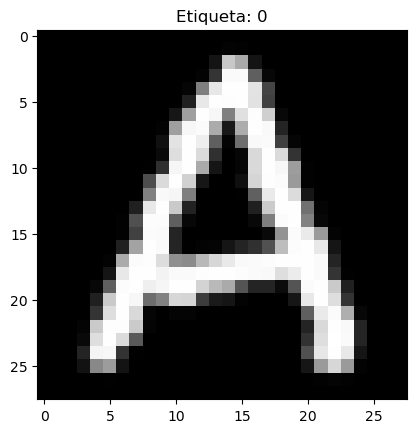

In [5]:
import matplotlib.pyplot as plt

plt.imshow(X_letters_train[32], cmap='gray')
plt.title(f"Etiqueta: {y_letters_train[32]}")
plt.show()

In [6]:
mat_digits = scipy.io.loadmat(r"C:\Users\joana\Documents\Projectes personals\TR\matlab\matlab\emnist-digits.mat")

# Dades d'entrenament
X_digits_train = mat_digits['dataset']['train'][0,0]['images'][0,0]
y_digits_train = mat_digits['dataset']['train'][0,0]['labels'][0,0]

# Dades de test
X_digits_test = mat_digits['dataset']['test'][0,0]['images'][0,0]
y_digits_test = mat_digits['dataset']['test'][0,0]['labels'][0,0]

In [7]:
# Format de les imatges (vector --> matriu 28x28)
X_digits_train = X_digits_train.reshape(-1, 28, 28, order='F').astype(np.uint8)
X_digits_test = X_digits_test.reshape(-1, 28, 28, order='F').astype(np.uint8)

# Ajusta etiquetes: els dígits van del 0 al 9, no cal restar 1
y_digits_train = y_digits_train.flatten()
y_digits_test = y_digits_test.flatten()

# Reassignar etiquetes dels dígits perquè no se solapin amb les lletres
y_digits_train += 26
y_digits_test += 26

In [8]:
# Unim els conjunts d'entrenament
X_train_total = np.concatenate([X_letters_train, X_digits_train], axis=0)
y_train_total = np.concatenate([y_letters_train, y_digits_train], axis=0)

# I els conjunts de test
X_test_total = np.concatenate([X_letters_test, X_digits_test], axis=0)
y_test_total = np.concatenate([y_letters_test, y_digits_test], axis=0)

# Normalització: valors entre 0 i 1
X_train_total = X_train_total / 255.0
X_test_total = X_test_total / 255.0

# Afegim canal (blanc i negre = 1 canal)
X_train_total = X_train_total.reshape(-1, 28, 28, 1)
X_test_total = X_test_total.reshape(-1, 28, 28, 1)

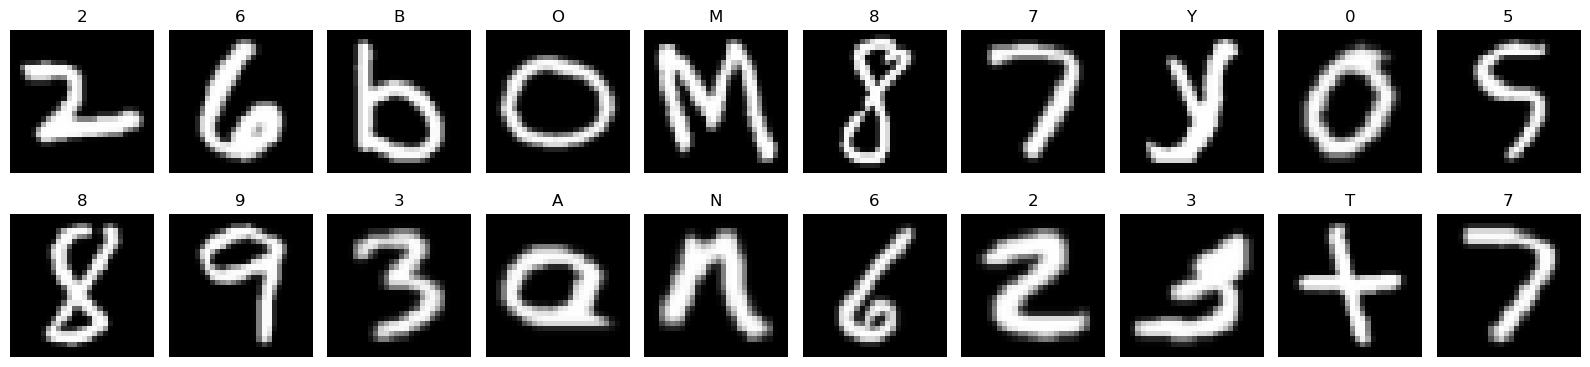

In [9]:
import string

# Mostra 20 imatges aleatòries del conjunt total
indices = np.random.choice(len(X_train_total), size=20, replace=False)

fig, axes = plt.subplots(2, 10, figsize=(16, 4))

for i, idx in enumerate(indices):
    row = i // 10
    col = i % 10
    ax = axes[row, col]
    
    ax.imshow(X_train_total[idx].squeeze(), cmap="gray")
    
    label = y_train_total[idx]
    if label < 26:
        # Lletra (A–Z)
        title = string.ascii_uppercase[label]
    else:
        # Dígit (0–9)
        title = str(label - 26)
        
    ax.set_title(f"{title}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
from sklearn.preprocessing import OneHotEncoder

# Inicialitzem l'encodificador
encoder = OneHotEncoder(sparse_output=False, categories='auto')

# Ajustem i transformem les etiquetes (cal reshaping per a columnes)
y_train_cat = encoder.fit_transform(y_train_total.reshape(-1, 1))
y_test_cat = encoder.transform(y_test_total.reshape(-1, 1))

print("Etiqueta original:", y_train_total[2])
print("One-hot encoded:", y_train_cat[2])

Etiqueta original: 15
One-hot encoded: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore

# Defineixo la CNN
model_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Redueix overfitting
    Dense(y_train_cat.shape[1], activation='softmax')  # Sortida: tantes neurones com classes
])

# Compilo
model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entreno
history_cnn = model_cnn.fit(
    X_train_total, y_train_cat,
    epochs=10,
    batch_size=128,
    validation_data=(X_test_total, y_test_cat),
    verbose=1
)

# Avaluació
test_loss, test_acc = model_cnn.evaluate(X_test_total, y_test_cat, verbose=0)
print(f"Precisió CNN: {test_acc:.4f}")


c:\Users\joana\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.8110 - loss: 0.6517 - val_accuracy: 0.9034 - val_loss: 0.3029
Epoch 2/10
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - accuracy: 0.8784 - loss: 0.3970 - val_accuracy: 0.9157 - val_loss: 0.2606
Epoch 3/10
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.8936 - loss: 0.3447 - val_accuracy: 0.9206 - val_loss: 0.2433
Epoch 4/10
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 0.9016 - loss: 0.3155 - val_accuracy: 0.9250 - val_loss: 0.2322
Epoch 5/10
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.9072 - loss: 0.2954 - val_accuracy: 0.9267 - val_loss: 0.2261
Epoch 6/10
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9110 - loss: 0.2803 - val_accuracy: 0.9288 - val_loss: 0.2174
Epoch 7/10
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step - accuracy: 0.9147 - loss: 0.2686 - val_accuracy: 0.9275 - val_loss: 0.2227
Epoch 8/10
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - accuracy: 0.9165 -